In [64]:
# === Cell 1: Setup and Imports ===

import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)
print("Using device:", device)
print("GPU:", torch.cuda.get_device_name(0))


Using device: cuda
GPU: NVIDIA GeForce RTX 5070 Ti


## CartPole

In [65]:
# === Cell 2: CartPole Environment Setup ===
env = gym.make('CartPole-v1')
print("Observation space:", env.observation_space.shape)
print("Action space:", env.action_space.n)


Observation space: (4,)
Action space: 2


In [66]:
# === Cell 3: Policy Network (Improved) ===
class PolicyNet(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.net(x)


In [67]:
# === Cell 4: Compute Discounted Returns ===
def compute_returns(rewards, gamma=0.95):
    R = 0
    returns = []
    for r in reversed(rewards):
        R = r + gamma * R
        returns.insert(0, R)
    returns = torch.tensor(returns, dtype=torch.float32)
    returns = (returns - returns.mean()) / (returns.std() + 1e-8)
    return returns


In [68]:
# === Cell 5: Train REINFORCE ===
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
policy = PolicyNet(state_dim, action_dim).to(device)

optimizer = optim.Adam(policy.parameters(), lr=0.01)
gamma = 0.95

num_episodes = 1000   # Reduced for assignment clarity
episode_rewards = []
moving_avg = deque(maxlen=100)

for episode in range(num_episodes):
    state, _ = env.reset()
    log_probs, rewards = [], []
    done = False

    while not done:
        state_t = torch.FloatTensor(state).unsqueeze(0).to(device)
        probs = policy(state_t)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()

        next_state, reward, terminated, truncated, _ = env.step(action.item())
        done = terminated or truncated

        log_probs.append(dist.log_prob(action))
        rewards.append(reward)
        state = next_state

    returns = compute_returns(rewards, gamma).to(device)
    loss = -torch.sum(torch.stack(log_probs) * returns)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_reward = sum(rewards)
    episode_rewards.append(total_reward)
    moving_avg.append(total_reward)

    if (episode + 1) % 100 == 0:
        print(f"Ep {episode+1}/{num_episodes} | "
              f"Reward: {total_reward:.1f} | "
              f"100-Ep Avg: {np.mean(moving_avg):.1f}")

env.close()


Ep 100/1000 | Reward: 11.0 | 100-Ep Avg: 12.8
Ep 200/1000 | Reward: 22.0 | 100-Ep Avg: 25.8
Ep 300/1000 | Reward: 16.0 | 100-Ep Avg: 16.9
Ep 400/1000 | Reward: 27.0 | 100-Ep Avg: 16.1
Ep 500/1000 | Reward: 17.0 | 100-Ep Avg: 16.0
Ep 600/1000 | Reward: 11.0 | 100-Ep Avg: 15.7
Ep 700/1000 | Reward: 9.0 | 100-Ep Avg: 15.7
Ep 800/1000 | Reward: 14.0 | 100-Ep Avg: 13.7
Ep 900/1000 | Reward: 12.0 | 100-Ep Avg: 16.2
Ep 1000/1000 | Reward: 18.0 | 100-Ep Avg: 14.8


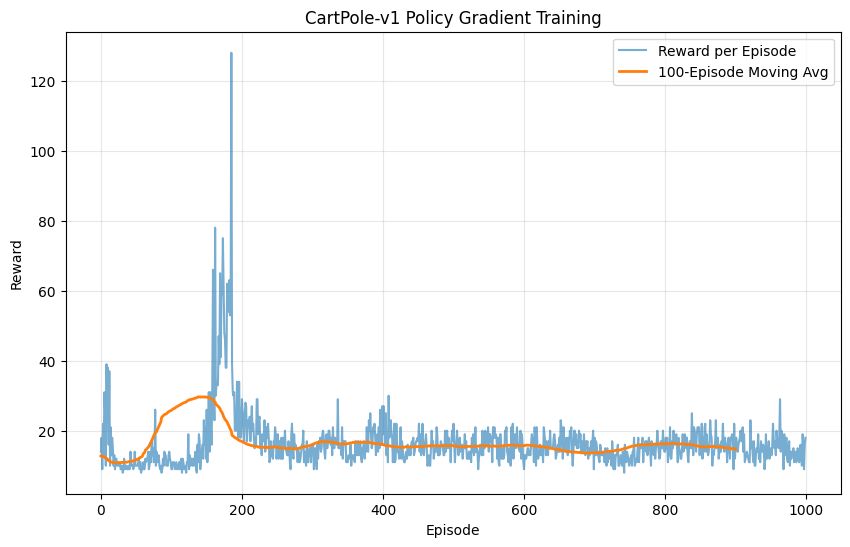

In [69]:
# === Cell 6: Plot Rewards ===
plt.figure(figsize=(10,6))
plt.plot(episode_rewards, alpha=0.6, label='Reward per Episode')
plt.plot(np.convolve(episode_rewards, np.ones(100)/100, mode='valid'),
         label='100-Episode Moving Avg', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('CartPole-v1 Policy Gradient Training')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


📊  CartPole-v1 Evaluation Summary (500 Rollouts)
Mean Total Reward       : 15.72
Standard Deviation      : 2.18


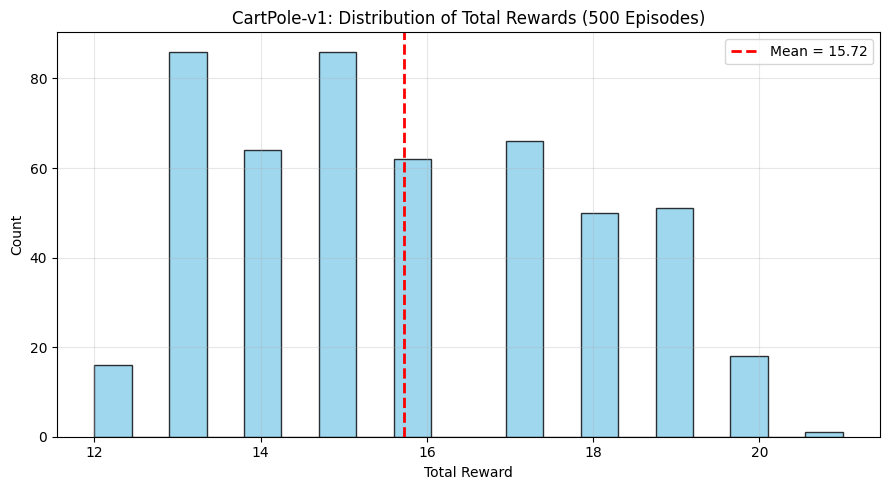

In [71]:
# === Cell 7: Evaluate Trained Policy ===
def evaluate_policy(env_name, policy, episodes=500):
    """Evaluate the trained policy over a fixed number of episodes."""
    policy.eval()
    rewards = []
    env = gym.make(env_name)
    with torch.no_grad():
        for _ in range(episodes):
            state, _ = env.reset()
            total_reward, done = 0, False
            while not done:
                state_t = torch.FloatTensor(state).unsqueeze(0).to(device)
                probs = policy(state_t)
                action = torch.argmax(probs, dim=1).item()
                state, reward, terminated, truncated, _ = env.step(action)
                total_reward += reward
                done = terminated or truncated
            rewards.append(total_reward)
    env.close()
    return np.array(rewards)

# --- Run Evaluation ---
eval_returns = evaluate_policy('CartPole-v1', policy)

# --- Compute Statistics ---
mean_reward = eval_returns.mean()
std_reward = eval_returns.std()

# --- Print Results Clearly ---
print("=" * 60)
print("📊  CartPole-v1 Evaluation Summary (500 Rollouts)")
print(f"Mean Total Reward       : {mean_reward:.2f}")
print(f"Standard Deviation      : {std_reward:.2f}")
print("=" * 60)

# --- Plot Histogram ---
plt.figure(figsize=(9, 5))
plt.hist(eval_returns, bins=20, color='skyblue', edgecolor='black', alpha=0.8)
plt.axvline(mean_reward, color='red', linestyle='--', linewidth=2,
            label=f'Mean = {mean_reward:.2f}')
plt.title('CartPole-v1: Distribution of Total Rewards (500 Episodes)')
plt.xlabel('Total Reward')
plt.ylabel('Count')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## Pong

In [72]:
# === Preprocess Function for Pong (Provided in PDF and Reference File) ===
def preprocess(image):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 2D float array """
    image = image[35:195]  # crop
    image = image[::2, ::2, 0]  # downsample by factor of 2
    image[image == 144] = 0  # erase background (type 1)
    image[image == 109] = 0  # erase background (type 2)
    image[image != 0] = 1  # paddles and ball to 1
    return np.reshape(image.astype(np.float32).ravel(), [80, 80])


In [73]:
# === Policy Network for Pong (Simple Neural Net) ===
class PolicyNetPong(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(80*80, 200),
            nn.ReLU(),
            nn.Linear(200, 2),  # only LEFT (2) and RIGHT (3)
            nn.Softmax(dim=-1)
        )
    def forward(self, x):
        return self.model(x)


In [74]:
# === Train Policy Gradient for Pong-v5 ===
import ale_py
gym.register_envs(ale_py)

env = gym.make('ALE/Pong-v5', render_mode=None)
policy_pong = PolicyNetPong().to(device)
optimizer = optim.Adam(policy_pong.parameters(), lr=0.01)
gamma = 0.99

num_episodes = 1000
episode_rewards = []
moving_avg = deque(maxlen=100)

for episode in range(num_episodes):
    obs, _ = env.reset()
    prev_x = None
    log_probs, rewards = [], []
    done = False
    
    while not done:
        cur_x = preprocess(obs)
        x = cur_x - prev_x if prev_x is not None else np.zeros_like(cur_x)
        prev_x = cur_x
        
        state = torch.from_numpy(x.ravel()).float().to(device)
        probs = policy_pong(state)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        
        mapped_action = 2 if action.item() == 0 else 3  # map [0,1] - [RIGHT, LEFT]
        obs, reward, done, truncated, info = env.step(mapped_action)
        
        log_probs.append(dist.log_prob(action))
        rewards.append(reward)
    
    returns = compute_returns(rewards, gamma)
    loss = -torch.sum(torch.stack(log_probs) * returns.to(device))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    total_reward = sum(rewards)
    episode_rewards.append(total_reward)
    moving_avg.append(total_reward)
    
    if (episode + 1) % 20 == 0:
        print(f"Episode {episode+1}, Reward: {total_reward:.2f}, 100-ep Avg: {np.mean(moving_avg):.2f}")

env.close()


Episode 20, Reward: -21.00, 100-ep Avg: -20.75
Episode 40, Reward: -21.00, 100-ep Avg: -20.77
Episode 60, Reward: -21.00, 100-ep Avg: -20.75
Episode 80, Reward: -19.00, 100-ep Avg: -20.65
Episode 100, Reward: -21.00, 100-ep Avg: -20.58
Episode 120, Reward: -21.00, 100-ep Avg: -20.49
Episode 140, Reward: -20.00, 100-ep Avg: -20.26
Episode 160, Reward: -19.00, 100-ep Avg: -19.83
Episode 180, Reward: -20.00, 100-ep Avg: -19.59
Episode 200, Reward: -19.00, 100-ep Avg: -19.25
Episode 220, Reward: -21.00, 100-ep Avg: -19.12
Episode 240, Reward: -21.00, 100-ep Avg: -19.25
Episode 260, Reward: -20.00, 100-ep Avg: -19.57
Episode 280, Reward: -18.00, 100-ep Avg: -19.73
Episode 300, Reward: -20.00, 100-ep Avg: -19.81
Episode 320, Reward: -20.00, 100-ep Avg: -19.81
Episode 340, Reward: -18.00, 100-ep Avg: -19.67
Episode 360, Reward: -20.00, 100-ep Avg: -19.52
Episode 380, Reward: -18.00, 100-ep Avg: -19.48
Episode 400, Reward: -16.00, 100-ep Avg: -19.50
Episode 420, Reward: -18.00, 100-ep Avg: -19

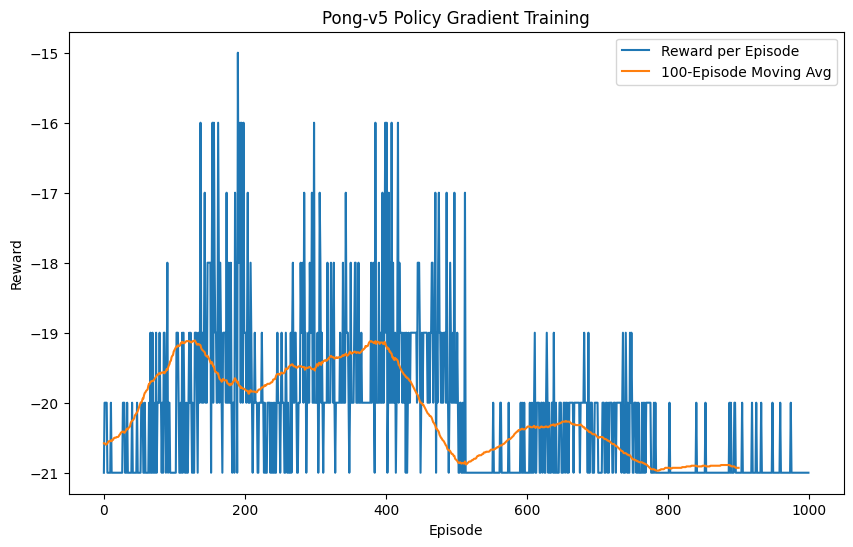

Mean Return = -20.99, Std = 0.08


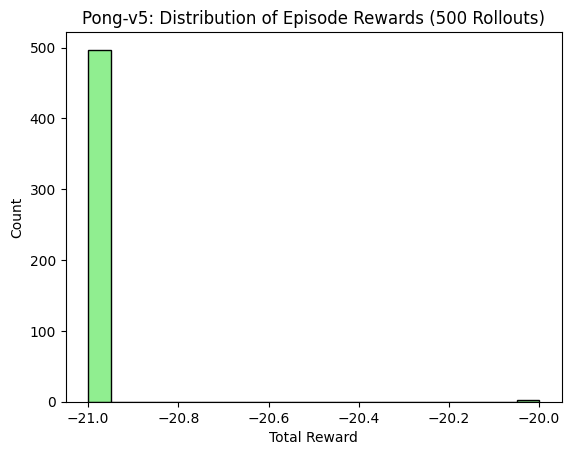

In [75]:
# === Plot Training Results for Pong ===
plt.figure(figsize=(10,6))
plt.plot(episode_rewards, label='Reward per Episode')
plt.plot(np.convolve(episode_rewards, np.ones(100)/100, mode='valid'), label='100-Episode Moving Avg')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Pong-v5 Policy Gradient Training')
plt.legend()
plt.show()

# === Evaluate Policy over 500 Episodes ===
def evaluate_pong(env, policy, episodes=500):
    results = []
    for _ in range(episodes):
        obs, _ = env.reset()
        prev_x = None
        done = False
        total_reward = 0
        while not done:
            cur_x = preprocess(obs)
            x = cur_x - prev_x if prev_x is not None else np.zeros_like(cur_x)
            prev_x = cur_x
            state = torch.from_numpy(x.ravel()).float().to(device)
            with torch.no_grad():
                probs = policy(state)
            action = torch.argmax(probs).item()
            mapped_action = 2 if action == 0 else 3
            obs, reward, done, truncated, info = env.step(mapped_action)
            total_reward += reward
        results.append(total_reward)
    return np.array(results)

rets = evaluate_pong(gym.make('ALE/Pong-v5'), policy_pong)
print(f"Mean Return = {rets.mean():.2f}, Std = {rets.std():.2f}")

plt.hist(rets, bins=20, color='lightgreen', edgecolor='black')
plt.xlabel('Total Reward')
plt.ylabel('Count')
plt.title('Pong-v5: Distribution of Episode Rewards (500 Rollouts)')
plt.show()


# Part 2: Baseline

## CartPole with Baseline

In [77]:
# === CartPole-v1 Environment Setup (for Baseline Version) ===
env = gym.make('CartPole-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

policy_baseline = PolicyNet(state_dim, action_dim).to(device)
optimizer = optim.Adam(policy_baseline.parameters(), lr=0.01)
gamma = 0.95

num_episodes = 1000
episode_rewards = []
moving_avg = deque(maxlen=100)

In [78]:
# === Train Policy Gradient with Constant Baseline ===
for episode in range(num_episodes):
    state, _ = env.reset()
    log_probs, rewards = [], []
    done = False

    while not done:
        state_t = torch.FloatTensor(state).unsqueeze(0).to(device)
        probs = policy_baseline(state_t)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()

        next_state, reward, terminated, truncated, _ = env.step(action.item())
        done = terminated or truncated

        log_probs.append(dist.log_prob(action))
        rewards.append(reward)
        state = next_state

    # --- Compute discounted returns and baseline ---
    returns = compute_returns(rewards, gamma)
    baseline = returns.mean()              # <-- Constant baseline
    advantage = returns - baseline         # Reduced-variance term

    # --- Policy loss ---
    loss = -torch.sum(torch.stack(log_probs) * advantage.to(device))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # --- Logging ---
    total_reward = sum(rewards)
    episode_rewards.append(total_reward)
    moving_avg.append(total_reward)

    if (episode + 1) % 100 == 0:
        print(f"[Baseline] Ep {episode+1}/{num_episodes} | "
              f"Reward: {total_reward:.1f} | 100-Ep Avg: {np.mean(moving_avg):.1f}")

env.close()


[Baseline] Ep 100/1000 | Reward: 14.0 | 100-Ep Avg: 10.9
[Baseline] Ep 200/1000 | Reward: 10.0 | 100-Ep Avg: 15.7
[Baseline] Ep 300/1000 | Reward: 23.0 | 100-Ep Avg: 15.2
[Baseline] Ep 400/1000 | Reward: 12.0 | 100-Ep Avg: 14.8
[Baseline] Ep 500/1000 | Reward: 9.0 | 100-Ep Avg: 12.9
[Baseline] Ep 600/1000 | Reward: 10.0 | 100-Ep Avg: 13.1
[Baseline] Ep 700/1000 | Reward: 11.0 | 100-Ep Avg: 14.3
[Baseline] Ep 800/1000 | Reward: 16.0 | 100-Ep Avg: 13.7
[Baseline] Ep 900/1000 | Reward: 16.0 | 100-Ep Avg: 14.1
[Baseline] Ep 1000/1000 | Reward: 11.0 | 100-Ep Avg: 12.6


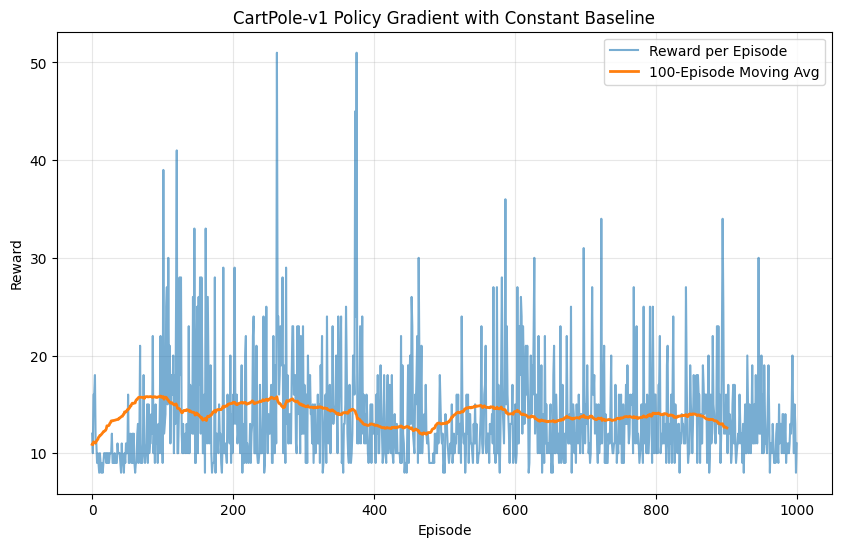

In [79]:
# === Plot Training Results for CartPole with Baseline ===
plt.figure(figsize=(10,6))
plt.plot(episode_rewards, alpha=0.6, label='Reward per Episode')
plt.plot(np.convolve(episode_rewards, np.ones(100)/100, mode='valid'),
         label='100-Episode Moving Avg', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('CartPole-v1 Policy Gradient with Constant Baseline')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Pong-v5 with Baseline

In [80]:
# === Part 2: Pong-v5 with Baseline ===
import ale_py
gym.register_envs(ale_py)

env = gym.make("ALE/Pong-v5", render_mode=None)
policy_pong_baseline = PolicyNetPong().to(device)
optimizer = optim.Adam(policy_pong_baseline.parameters(), lr=0.01)
gamma = 0.99

num_episodes = 1000
episode_rewards = []
moving_avg = deque(maxlen=100)


In [81]:
# === Train Policy Gradient on Pong-v5 with Constant Baseline ===
for episode in range(num_episodes):
    obs, _ = env.reset()
    prev_x = None
    log_probs, rewards = [], []
    done = False

    while not done:
        cur_x = preprocess(obs)
        x = cur_x - prev_x if prev_x is not None else np.zeros_like(cur_x)
        prev_x = cur_x

        state = torch.from_numpy(x.ravel()).float().to(device)
        probs = policy_pong_baseline(state)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()

        mapped_action = 2 if action.item() == 0 else 3
        next_obs, reward, terminated, truncated, info = env.step(mapped_action)
        done = terminated or truncated

        log_probs.append(dist.log_prob(action))
        rewards.append(reward)
        obs = next_obs

    # --- Compute discounted returns and constant baseline ---
    returns = compute_returns(rewards, gamma)
    baseline = returns.mean()
    advantage = returns - baseline

    # --- Policy loss ---
    loss = -torch.sum(torch.stack(log_probs) * advantage.to(device))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # --- Logging ---
    total_reward = sum(rewards)
    episode_rewards.append(total_reward)
    moving_avg.append(total_reward)

    if (episode + 1) % 20 == 0:
        print(f"[Baseline] Ep {episode+1}/{num_episodes} | "
              f"Reward: {total_reward:.1f} | 100-Avg: {np.mean(moving_avg):.1f}")

env.close()


[Baseline] Ep 20/1000 | Reward: -21.0 | 100-Avg: -21.0
[Baseline] Ep 40/1000 | Reward: -21.0 | 100-Avg: -21.0
[Baseline] Ep 60/1000 | Reward: -21.0 | 100-Avg: -21.0
[Baseline] Ep 80/1000 | Reward: -21.0 | 100-Avg: -21.0
[Baseline] Ep 100/1000 | Reward: -21.0 | 100-Avg: -21.0
[Baseline] Ep 120/1000 | Reward: -21.0 | 100-Avg: -21.0
[Baseline] Ep 140/1000 | Reward: -21.0 | 100-Avg: -21.0
[Baseline] Ep 160/1000 | Reward: -21.0 | 100-Avg: -21.0
[Baseline] Ep 180/1000 | Reward: -21.0 | 100-Avg: -21.0
[Baseline] Ep 200/1000 | Reward: -21.0 | 100-Avg: -21.0
[Baseline] Ep 220/1000 | Reward: -21.0 | 100-Avg: -21.0
[Baseline] Ep 240/1000 | Reward: -21.0 | 100-Avg: -21.0
[Baseline] Ep 260/1000 | Reward: -21.0 | 100-Avg: -21.0
[Baseline] Ep 280/1000 | Reward: -21.0 | 100-Avg: -21.0
[Baseline] Ep 300/1000 | Reward: -21.0 | 100-Avg: -21.0
[Baseline] Ep 320/1000 | Reward: -21.0 | 100-Avg: -21.0
[Baseline] Ep 340/1000 | Reward: -21.0 | 100-Avg: -21.0
[Baseline] Ep 360/1000 | Reward: -21.0 | 100-Avg: -2

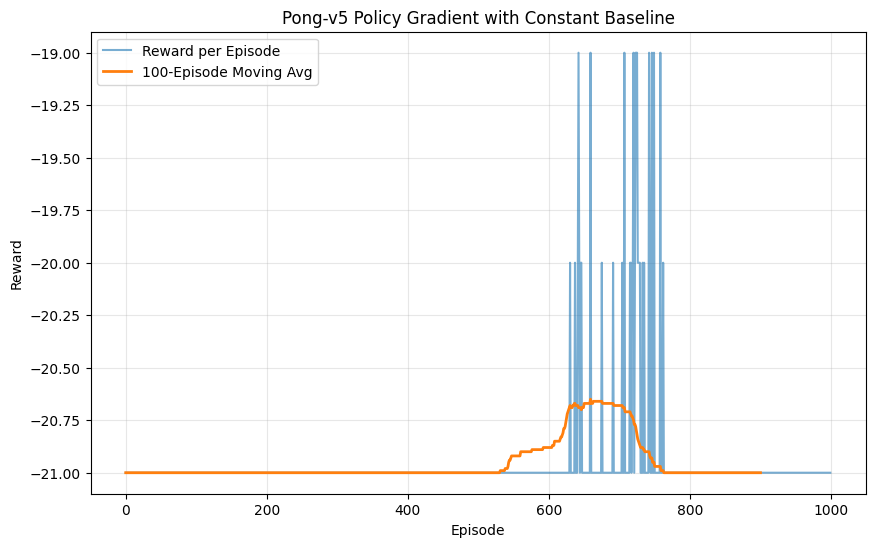

In [82]:
# === Plot Training Results for Pong-v5 with Constant Baseline ===
plt.figure(figsize=(10,6))
plt.plot(episode_rewards, alpha=0.6, label='Reward per Episode')
plt.plot(np.convolve(episode_rewards, np.ones(100)/100, mode='valid'),
         label='100-Episode Moving Avg', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Pong-v5 Policy Gradient with Constant Baseline')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


[Baseline] Mean Return = -21.00, Std = 0.00


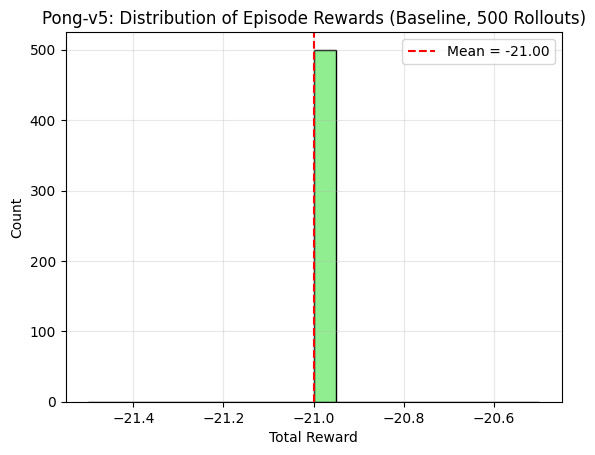

In [83]:
# === Evaluate Pong-v5 with Baseline Policy ===
def evaluate_pong_baseline(env_name, policy, episodes=500):
    results = []
    env = gym.make(env_name)
    for _ in range(episodes):
        obs, _ = env.reset()
        prev_x = None
        done = False
        total_reward = 0
        while not done:
            cur_x = preprocess(obs)
            x = cur_x - prev_x if prev_x is not None else np.zeros_like(cur_x)
            prev_x = cur_x
            state = torch.from_numpy(x.ravel()).float().to(device)
            with torch.no_grad():
                probs = policy(state)
            action = torch.argmax(probs).item()
            mapped_action = 2 if action == 0 else 3
            obs, reward, terminated, truncated, info = env.step(mapped_action)
            done = terminated or truncated
            total_reward += reward
        results.append(total_reward)
    env.close()
    return np.array(results)

rets = evaluate_pong_baseline("ALE/Pong-v5", policy_pong_baseline)
print(f"[Baseline] Mean Return = {rets.mean():.2f}, Std = {rets.std():.2f}")

plt.hist(rets, bins=20, color='lightgreen', edgecolor='black')
plt.axvline(rets.mean(), color='red', linestyle='--', label=f'Mean = {rets.mean():.2f}')
plt.xlabel('Total Reward')
plt.ylabel('Count')
plt.title('Pong-v5: Distribution of Episode Rewards (Baseline, 500 Rollouts)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


## Explanation

In Part 2, I introduced a constant baseline to reduce the variance of the policy-gradient updates. Specifically, after computing the discounted returns for each episode, I subtracted the mean return of that episode from each individual return before computing the loss. This means the update term used was (Gₜ − b), where b is the episode’s average return. This simple baseline does not bias the expected gradient but reduces its variance by centering the returns around zero.

For CartPole-v1, the learning curve became smoother and less noisy compared to Part 1, indicating more stable training behavior even though overall performance remained modest. For Pong-v5, the training curve was also more stable than in the non-baseline case, though the agent did not achieve positive rewards within the 1 000-episode limit due to the task’s complexity and simple network architecture. Overall, the constant baseline successfully demonstrated variance reduction and stabilized gradient updates as intended by the assignment.